## This is a showcase of the usage of ART - a package inspired by Andrej Karpathy's blog post.

### In this tutorial, you will be presented with how to use ART to perform a very popular form of model training - the transfer learning, while following steps recommended by Andrej Karpathy.

Let's start with the dataset. Since ART is based on Pytorch-Lightning, we need to create LightningDataModule.\
For this tutorial, I decided to use a very well known dataset called Cifar100 and I wrapped it into LightningDataModule creating [CifarDataModule](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/dataset.py)

Okay, we have datamodule, but how do we use it?\
Let us introduce you, to the core of ART, the ArtProject.

In [1]:
from dataset import CifarDataModule
from art.project import ArtProject
project_name = "Cifar100"
dataset = CifarDataModule(batch_size=32)
project = ArtProject(project_name, dataset)
force_rerun = False # whole process is saved in checkpoints, for fast rerun. 
                   # If you want to use it set to False

Now, that we have a Datamodule and ArtProject let's perform the first step: \
**Become one with the data**


To achieve this, we'll perform some data analysis.\
Firstly, create a new step for our project - Data analysis\
Here is what it could look like: [Data analysis step](https://github.com/SebChw/ART-Templates/blob/4c10a65fa8f7356933105ce78b694cbcbed3b6d0/%7B%7Bcookiecutter.project_slug%7D%7D/steps.py#L9)

In this class, we check multiple characteristics of the data:
* The number of classes
* Names of classes
* Whether the dataset is balanced - number of examples in each class
* The dimensions of the images
* We get to know the actual visualizations of the images (10 visualizations per class)

Let's insert it into the ArtProject

In [2]:
from checks import CheckClassImagesExist, CheckLenClassNamesEqualToNumClasses
from steps import DataAnalysis
from art.checks import CheckResultExists
project.add_step(DataAnalysis(), [
    CheckResultExists("number_of_classes"),
    CheckResultExists("class_names"),
    CheckResultExists("number_of_examples_in_each_class"),
    CheckResultExists("img_dimensions"),
    CheckClassImagesExist(),
    CheckLenClassNamesEqualToNumClasses()])
project.run_all(force_rerun=force_rerun)


Summary: 
Step: Data analysis, Model: , Passed: True. Results:



You can see that there are some checks except for the data analysis step.\
Those checks are run after the step so that we can be sure that everything went as planned.\
**You**, as the user of ART, are responsible for creating checks that will suit your experiments.\
We used only two **custom** [checks](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/checks.py) and one universal check implemented into art: [CheckResultExists](https://github.com/SebChw/Actually-Robust-Training/blob/main/art/checks.py#L82).


Let's see the results:

Number of classes:  100
All classes names:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 't

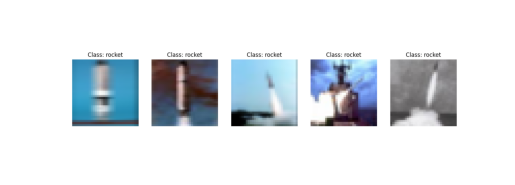

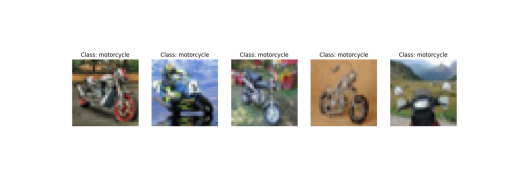

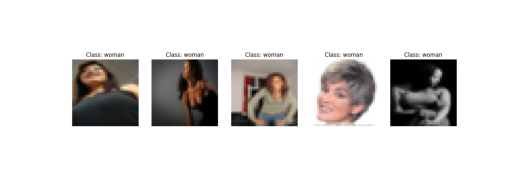

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from os.path import normpath
results = project.get_step(0).get_latest_run()
print("Number of classes: ", results["number_of_classes"])
print("All classes names: ", results["class_names"])
print("Number of examples in each class: ", [(x, y) for x, y in results["number_of_examples_in_each_class"].items()][:5], "...")
print(f"All classes have the same number of examples: {all(i == [x for x in results['number_of_examples_in_each_class'].values()][0] for i in [x for x in results['number_of_examples_in_each_class'].values()])}.")
print("Dimentions of images: ", results["img_dimensions"])
for i in range(3):
    img_class = results["class_names"][random.randint(0, 100)]
    img_path = normpath(f"art_checkpoints/Data analysis/{project.get_step(0).get_class_image_path(img_class)}")
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    


We can see, that the dataset is perfectly balanced, and indeed has 100 classes as its name suggests.

Now that we know something about our dataset, we can proceed to the next steps. It is time to decide, what **metrics** will we use in our project.

In [4]:
from torchmetrics import Accuracy
import torch.nn as nn
from art.steps import EvaluateBaseline

NUM_CLASSES = project.get_step(0).get_latest_run()["number_of_classes"]
accuracy_metric, ce_loss = Accuracy(task="multiclass", num_classes = NUM_CLASSES), nn.CrossEntropyLoss()
# Register metrics, that you want to be calculated for every model that you will be using
project.register_metrics([accuracy_metric, ce_loss])

Having registered the metrics, we can proceed to the next step which is to **Add baselines**. We want to make sure, that everything we have done until this moment, works as it should, and there are no bugs in our DataLoader.\
For this purpose, we used three [baselines](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/models/baselines.py).\
Feel free to implement yours however you like, but remember to follow the structure of ArtModule.

In [5]:
from art.metrics import SkippedMetric
from models.baselines import MlBaseline, HeuristicBaseline, AlreadyExistingResNet20Baseline
from art.checks import CheckScoreExists
baselines = [HeuristicBaseline, MlBaseline, AlreadyExistingResNet20Baseline]
for baseline in baselines:
    project.add_step(
        step = EvaluateBaseline(baseline), 
        checks = [CheckScoreExists(metric=accuracy_metric)],
        skipped_metrics=[SkippedMetric(metric=ce_loss)]
    )


In [6]:
project.run_all(force_rerun=force_rerun)

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753


Nice, we can see that MLBaseline is better than random selection, and that pretrained ResNet20 performs quite well.

Now, that we are sure, that our pipeline works as intended, we can start implementing our model.\
We will start with yet another good pracitce which is **check loss on init** - we want to make sure, that our model, which didn't see any of the Cifar100 data, will give us **loss** equal to `-log(1/100)`.

In [7]:
# from models.ResNet import ResNet
from models.EfficientNet import EfficientNet
from art.steps import CheckLossOnInit
from art.checks import CheckScoreCloseTo
import math

EXPECTED_LOSS = -math.log(1/NUM_CLASSES)
print(EXPECTED_LOSS)

4.605170185988091


We'll add new stop to the project `CheckLossOnInit`.

In [8]:
project.add_step(
        CheckLossOnInit(EfficientNet),
        [CheckScoreCloseTo(metric=ce_loss,
                           value=EXPECTED_LOSS, rel_tol=0.1)]
    )

project.run_all(force_rerun=force_rerun)

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753
Step: Check Loss On Init, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-validate: 0.00675999978557229
	CrossEntropyLoss-validate: 4.893486022949219


Great, the loss looks good!\
The next step we want to perform, is to **overfit one batch** of our data. Thanks to this, we can be sure that our model is properly implemented.

In [9]:
from art.steps import OverfitOneBatch
from art.checks import CheckScoreLessThan
project.add_step(OverfitOneBatch(EfficientNet, number_of_steps=40),
            [CheckScoreLessThan(metric=ce_loss, value=0.05)])
project.run_all(force_rerun=force_rerun)

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753
Step: Check Loss On Init, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-validate: 0.00675999978557229
	CrossEntropyLoss-validate: 4.893486022949219
Step: Overfit One Batch, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-train: 1.0
	CrossEntropyLoss-train: 2.902682354033459e-05


And we will do the same, for the whole dataset.

In [10]:
from art.steps import Overfit
from art.checks import CheckScoreGreaterThan

project.add_step(Overfit(EfficientNet, max_epochs=10),
            [CheckScoreGreaterThan(metric=accuracy_metric, value=0.8)])

In [11]:
project.run_all(force_rerun=force_rerun)

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753
Step: Check Loss On Init, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-validate: 0.00675999978557229
	CrossEntropyLoss-validate: 4.893486022949219
Step: Overfit One Batch, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-train: 1.0
	CrossEntropyLoss-train: 2.902682354033459e-05
Step: Overfit, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-train: 0.9455999732017517
	CrossEntropyLoss-train: 0.16572201251983643
	MulticlassAccuracy-validate: 0.7613999843597412
	CrossEntropyLoss-validate: 1.198697209358215

Now, that the model passed all steps and checks we can finaly proceed with the **transfer learning**!

In [12]:
from art.steps import TransferLearning
from art.loggers import NeptuneLoggerAdapter
from lightning.pytorch.callbacks import EarlyStopping

early_stopping = EarlyStopping('CrossEntropyLoss-validate', patience=6)
project.add_step(TransferLearning(EfficientNet,
                                    freezed_trainer_kwargs={"max_epochs": 4,
                                                            "check_val_every_n_epoch": 2,
                                                            "callbacks": [early_stopping]},
                                    unfreezed_trainer_kwargs={"max_epochs": 50,
                                                            "check_val_every_n_epoch": 2,
                                                            "callbacks": [early_stopping]},
                                    keep_unfrozen=1,
                                    ),
                    [CheckScoreGreaterThan(metric=accuracy_metric, value=0.70)])

In [13]:
project.run_all(force_rerun=force_rerun)

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753
Step: Check Loss On Init, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-validate: 0.00675999978557229
	CrossEntropyLoss-validate: 4.893486022949219
Step: Overfit One Batch, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-train: 1.0
	CrossEntropyLoss-train: 2.902682354033459e-05
Step: Overfit, Model: EfficientNet, Passed: True. Results:
	MulticlassAccuracy-train: 0.9455999732017517
	CrossEntropyLoss-train: 0.16572201251983643
	MulticlassAccuracy-validate: 0.7613999843597412
	CrossEntropyLoss-validate: 1.198697209358215

We are all done! We achieved 76,1% of accuracy using a small [EfficientNet](https://huggingface.co/timm/efficientnet_b2.ra_in1k), running only couple of epochs!